# Understanding South by Southwest Tweet Content

## Overview

Analysis and natural language processing in order to create a Multinomial Naive Bayes model that will accurately predict the sentiment of a tweet.

## Business Problem

South by Southwest (SXSW) is an annual conference and festival that showcases innovations in technology and the creative arts.  In order to enhance the experience for future attendees, this company is looking to analyze the sentiments of tweets from previous years. 

Our task is to build a model that can correctly identify the sentiment of a tweet based on it's text. Not only will this give them insight on the public opinion on the conference and the brands in attendance, but it will allow them to identify the sentiment of future tweets in order to understand how a current conference is progressing.

## Dataset

We will be using a dataset from CrowdFlower that includes 9000 tweets relating to previous South by Southwest events.  The tweets are labeled as 'Negative', 'Positive', or 'No Emotion' and identify the brand or product they are related to.

# Data Understanding

In [269]:
# Import necessary libraries and packages
import pandas as pd
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import nltk
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

## Data Cleaning

In [270]:
# Download dataset and view the basic format
df = pd.read_csv('Data/data_from_tweets.csv', encoding='latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [271]:
# Rename columns for ease of use
df = df.rename(columns = {'tweet_text':'text',
                          'emotion_in_tweet_is_directed_at':'product',
                          'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'})

In [272]:
# Check overall dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [273]:
# Check for missing values
df.isna().sum()

text            1
product      5802
sentiment       0
dtype: int64

In [274]:
# Drop the one entry with a missing text value
df.dropna(subset=['text'], inplace=True)

In [275]:
df.isna().sum()

text            0
product      5801
sentiment       0
dtype: int64

In [276]:
# Reset the dataframe index
df.reset_index(drop=True, inplace=True)

In [277]:
# Explore product values
df['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

In [278]:
df['product'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [279]:
# Rename product values so we are only working with Apple or Google
for index in range(len(df)):
    if df['product'][index] in ['iPhone', 'iPad or iPhone App', 
                                'iPad', 'Apple', 
                                'Other Apple product or service']:
        df['product'][index] = 'Apple'
    elif df['product'][index] in ['Google', 'Android', 
                                  'Android App', 
                                  'Other Google product or service']:
        df['product'][index] = 'Google'
    else:
        pass

In [280]:
df['product'].value_counts()

Apple     2409
Google     882
Name: product, dtype: int64

In [281]:
df['product'].isna().sum()

5801

Since we are missing so many product labels, we will iterate through the tweet texts to find words pertaining to either Apple or Google. This will help us to identify many of our missing labels.

In [282]:
# Normally, this step would occue in Language Processing
# However, we want to capture as many entries as we can to identify the product
df['text'] = df['text'].str.lower()

In [283]:
google_words = ['android', '#google', 'google']
apple_words = ['iphone', 'ipad', 'mac', 'apple', '#apple']

for index in range(len(df)):
    if any(word in df['text'][index] for word in google_words) == True:
        df['product'][index] = 'Google'
    else:
        pass
for index in range(len(df)):
    if any(word in df['text'][index] for word in apple_words) == True:
        df['product'][index] = 'Apple'
    else:
        pass

In [284]:
df['product'].value_counts()

Apple     5569
Google    2767
Name: product, dtype: int64

In [285]:
df['product'].isna().sum()

756

This step has successfully reduced our missing values from 5801 to 756.

In [286]:
# Fill the remaining missing values with 'Unknown'
df.fillna(value='Unknown', inplace=True)

In [287]:
df['product'].isna().sum()

0

In [288]:
# Check the values for sentiment
df['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [289]:
# Remove entries where the sentiment is unknown
df = df[df['sentiment'] != "I can't tell"]

In [290]:
df['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: sentiment, dtype: int64

## Explore Cleaned Data

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       8936 non-null   object
 1   product    8936 non-null   object
 2   sentiment  8936 non-null   object
dtypes: object(3)
memory usage: 279.2+ KB


In [292]:
# View sentiment of texts for Apple vs Google
pd.DataFrame(df.groupby(['product', 'sentiment'])['text'].count())

text
product sentiment                               
Apple   Negative emotion                     425
        No emotion toward brand or product  2886
        Positive emotion                    2158
Google  Negative emotion                     144
        No emotion toward brand or product  1766
        Positive emotion                     807
Unknown Negative emotion                       1
        No emotion toward brand or product   736
        Positive emotion                      13

In [293]:
df['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: sentiment, dtype: int64

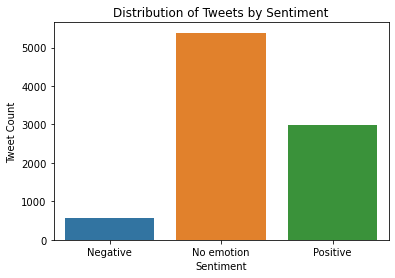

In [294]:
# View overall distribution of tweets by sentiment
fig, ax = plt.subplots()

classes = ['Negative emotion', 
           'No emotion toward brand or product', 
           'Positive emotion']
sns.countplot(x='sentiment', data=df, order=classes)

ax.set(xticklabels=['Negative', 'No emotion', 'Positive'], 
       xlabel='Sentiment', ylabel='Tweet Count', 
       title='Distribution of Tweets by Sentiment')

plt.show()

The overwhelming majority of tweets have no emotion as their label.  By randomly assigning 'No Emotion' to all the tweets, we would be correct 60% of the time.

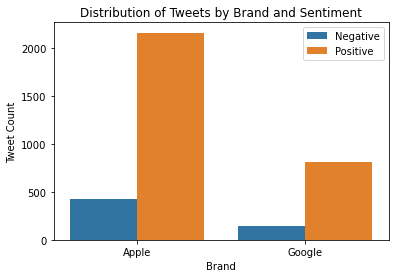

In [295]:
# View distribution of tweets by brand and senitment
brands = df.loc[(df['product']!='Unknown') & 
                (df['sentiment']!='No emotion toward brand or product')]

fig, ax = plt.subplots()
sns.countplot(x='product', data=brands, hue='sentiment')

ax.set(title='Distribution of Tweets by Brand and Sentiment', 
       xticklabels=['Apple', 'Google'], 
       xlabel='Brand', ylabel='Tweet Count')
ax.legend(['Negative', 'Positive'])

plt.show()

This plot shows that Apple was tweeted more than Google.  However, the percentage of positive vs negative tweets for both are fairly comparable.

## Train Test Split

In [296]:
# Create data and target dataframes
X = df.drop(['sentiment'], axis=1)
y = df['sentiment']

In [297]:
# Train test split
# Specify to stratify since our target is imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    random_state=42, 
                                                    stratify=y)

In [298]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6255 entries, 298 to 1594
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     6255 non-null   object
 1   product  6255 non-null   object
dtypes: object(2)
memory usage: 146.6+ KB


## Build a Baseline Model

In [299]:
# Vectorize X_train text
tfidf = TfidfVectorizer(max_features=20)
X_train_vectorized = tfidf.fit_transform(X_train['text'])
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, 
                                  columns=tfidf.get_feature_names())

,and,apple,at,for,google,in,ipad,iphone,is,link,mention,of,on,quot,rt,store,sxsw,the,to,up
0,0.000000,0.583447,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.387202,0.000000,0.0,0.000000,0.000000,0.672194,0.240456,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.345653,0.0,0.000000,0.0,0.000000,0.0,0.0,0.279743,0.509626,0.000000,0.0,0.000000,0.000000,0.442362,0.158241,0.307327,0.000000,0.476839
2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.729866,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.312932,0.607758,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.0,0.446104,0.0,0.000000,0.0,0.0,0.340061,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.192361,0.000000,0.805200,0.000000
4,0.000000,0.000000,0.443590,0.0,0.470954,0.0,0.000000,0.0,0.0,0.359005,0.327011,0.000000,0.0,0.000000,0.000000,0.000000,0.406154,0.000000,0.425027,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,0.000000,0.000000,0.000000,0.0,0.623374,0.0,0.000000,0.0,0.0,0.000000,0.432845,0.000000,0.0,0.000000,0.593124,0.000000,0.268801,0.000000,0.000000,0.000000
6251,0.000000,0.388882,0.350085,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.447725,0.0,0.000000,0.000000,0.000000,0.160270,0.622535,0.335435,0.000000
6252,0.482216,0.420425,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.279013,0.000000,0.0,0.592731,0.000000,0.000000,0.173270,0.000000,0.362643,0.000000
6253,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.754136,0.0,0.0,0.571604,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.323338,0.000000,0.000000,0.000000


In [300]:
#Multinomial Bayes Baseline Model
baseline_model = MultinomialNB()

# Evaluate the model on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

array([0.60351719, 0.60271783, 0.60271783, 0.60271783, 0.60271783])

This baseline model is performing right around 60%, approximately the same as if we assigned 'No Emotion' to all tweets.  We will attempt to increase this accuracy through natural language processing and feature engineering.

# Natural Language Processing

## Tokenize and Remove Punctuation

In [301]:
# Create a basic token pattern to remove punctuation when tokenizing
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

In [302]:
# Create a new columns for tokenized text
X_train['text_tokenized'] = X_train['text'].apply(tokenizer.tokenize)

In [303]:
X_train.head()

,text,product,text_tokenized
298,temporary apple store opens @mention 6th &amp;...,Apple,"[temporary, apple, store, opens, mention, 6th,..."
4176,#ipad2 delivery at the pop up @mention store @...,Apple,"[ipad2, delivery, at, the, pop, up, mention, s..."
882,i think i might go all weekend without seeing ...,Apple,"[think, might, go, all, weekend, without, seei..."
776,google to launch major new social network call...,Google,"[google, to, launch, major, new, social, netwo..."
622,google to host developer day at sxsw {link} #s...,Google,"[google, to, host, developer, day, at, sxsw, l..."


## Feature Engineering

### Remove Stopwords

Before we remove stopwords from our training set, lets look at our current top 20 words.

In [304]:
train_freq_dist = FreqDist(X_train['text_tokenized'].explode())
train_freq_dist

FreqDist({'sxsw': 6629, 'mention': 4905, 'the': 3085, 'link': 2978, 'to': 2486, 'at': 2113, 'rt': 2074, 'google': 1812, 'for': 1744, 'ipad': 1729, ...})

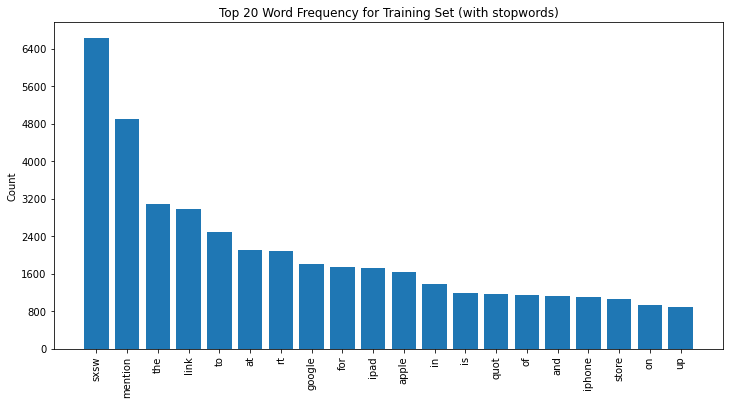

In [305]:
def visualize_top_20(freq_dist, title):

    top_20 = list(zip(*freq_dist.most_common(20)))
    tokens = top_20[0]
    counts = top_20[1]

    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(tokens, counts)

    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
visualize_top_20(train_freq_dist, 
                 "Top 20 Word Frequency for Training Set (with stopwords)")

The majority, if not all, of these top 20 words are either stopwords or words pertaining to South by Southwest, Google, or Apple that do not carry any information on sentiment.  I will remove these words to pare down our text to more meaningful words.

In [306]:
# Create a list of english stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [307]:
# Add words specific to SXSW, Apple, or Google
sxsw = ['sxsw', 'sxswi', 'mention', 'link', 'rt', 'rtmention', 'quot', 
        'austin', 'google', 'ipad', 'apple', 'iphone', 'amp', 
        'android', 'ipad2']
stopwords.extend(sxsw)

In [308]:
# Create a function for removing stopwords
def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords]
    return stopwords_removed

In [309]:
# Create a new column for text without stopwords
X_train['text_without_stopwords'] = X_train['text_tokenized'].apply(remove_stopwords)

In [310]:
X_train.head()

,text,product,text_tokenized,text_without_stopwords
298,temporary apple store opens @mention 6th &amp;...,Apple,"[temporary, apple, store, opens, mention, 6th,...","[temporary, store, opens, 6th, congress, tomor..."
4176,#ipad2 delivery at the pop up @mention store @...,Apple,"[ipad2, delivery, at, the, pop, up, mention, s...","[delivery, pop, store, quite, possible]"
882,i think i might go all weekend without seeing ...,Apple,"[think, might, go, all, weekend, without, seei...","[think, might, go, weekend, without, seeing, c..."
776,google to launch major new social network call...,Google,"[google, to, launch, major, new, social, netwo...","[launch, major, new, social, network, called, ..."
622,google to host developer day at sxsw {link} #s...,Google,"[google, to, host, developer, day, at, sxsw, l...","[host, developer, day]"


Now that we have removed stopwords, lets look at our top 20 words again.

In [311]:
new_train_freq_dist = FreqDist(X_train['text_without_stopwords'].explode())

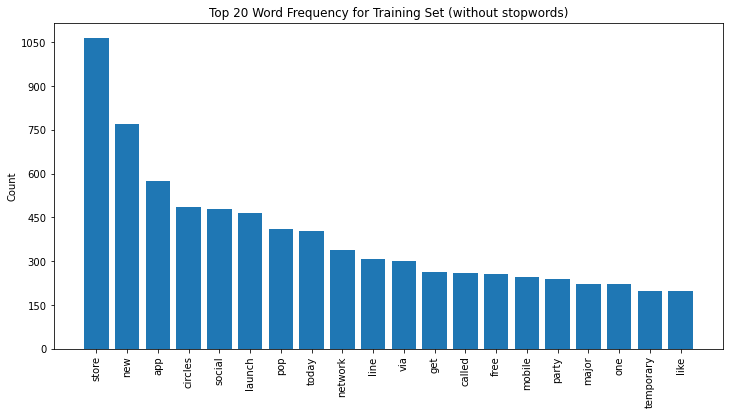

In [312]:
visualize_top_20(new_train_freq_dist, 
                 "Top 20 Word Frequency for Training Set (without stopwords)")

### Second Model

In [313]:
# Vetorize X_train text without stopwords
tfidf = TfidfVectorizer(max_features=20, stop_words=stopwords)

X_train_vectorized_2 = tfidf.fit_transform(X_train["text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_2, 
                                  columns=tfidf.get_feature_names())

,app,called,circles,free,get,launch,like,line,major,mobile,network,new,one,party,pop,social,store,temporary,today,via
0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.531619,0.846984,0.000000,0.0
1,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.802991,0.000000,0.595991,0.000000,0.000000,0.0
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.0,0.390767,0.337943,0.0,0.000000,0.336924,0.0,0.0,0.405584,0.0,0.366461,0.291352,0.0,0.0,0.000000,0.336319,0.000000,0.000000,0.350413,0.0
4,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6251,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
6252,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6253,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [314]:
# Evaluate the baseline model on the text without stopwords
stopwords_removed_cv = cross_val_score(baseline_model, 
                                       X_train_vectorized_2, 
                                       y_train)
stopwords_removed_cv

array([0.61550759, 0.60671463, 0.60431655, 0.60431655, 0.61231015])

In [315]:
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())

Baseline:          0.6028776978417267
Stopwords removed: 0.6086330935251799


This second model is performing slightly better than our baseline. Our next step to improve our model's performance is Lemmatization.

### Lemmatization

Lemmatization reduces each token to it's root word. For example, 'texts' and 'texting' would both be reduced to 'text'.

In [316]:
# Create a function for lemmatizing
lemmatizer = WordNetLemmatizer()
def lemmatize_text(token_list):
    lemmatized_text = [lemmatizer.lemmatize(word) for word in token_list]
    return lemmatized_text

In [317]:
# Create a new column for lemmatized text
X_train['lemmatized_text'] = X_train['text_without_stopwords'].apply(lemmatize_text)

In [318]:
X_train.head()

,text,product,text_tokenized,text_without_stopwords,lemmatized_text
298,temporary apple store opens @mention 6th &amp;...,Apple,"[temporary, apple, store, opens, mention, 6th,...","[temporary, store, opens, 6th, congress, tomor...","[temporary, store, open, 6th, congress, tomorrow]"
4176,#ipad2 delivery at the pop up @mention store @...,Apple,"[ipad2, delivery, at, the, pop, up, mention, s...","[delivery, pop, store, quite, possible]","[delivery, pop, store, quite, possible]"
882,i think i might go all weekend without seeing ...,Apple,"[think, might, go, all, weekend, without, seei...","[think, might, go, weekend, without, seeing, c...","[think, might, go, weekend, without, seeing, c..."
776,google to launch major new social network call...,Google,"[google, to, launch, major, new, social, netwo...","[launch, major, new, social, network, called, ...","[launch, major, new, social, network, called, ..."
622,google to host developer day at sxsw {link} #s...,Google,"[google, to, host, developer, day, at, sxsw, l...","[host, developer, day]","[host, developer, day]"


In [319]:
lemmatized_freq_dist = FreqDist(X_train['lemmatized_text'].explode())

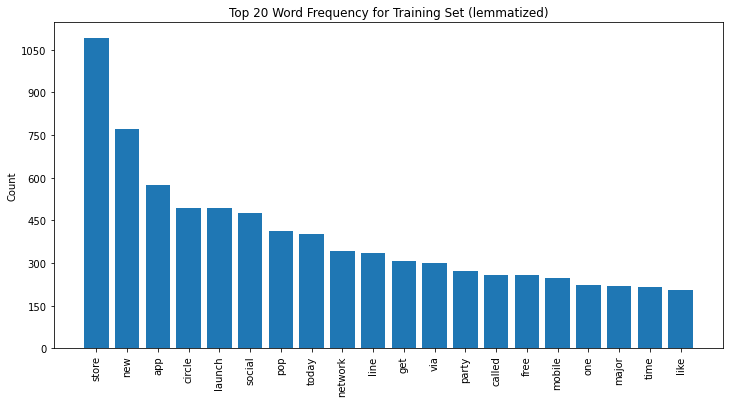

In [320]:
visualize_top_20(lemmatized_freq_dist, 
                 "Top 20 Word Frequency for Training Set (lemmatized)")

In [321]:
# Create a new column for the final text string
X_train['final_text'] = X_train['lemmatized_text'].apply(lambda x: ' '.join(x))

In [322]:
X_train.head()

,text,product,text_tokenized,text_without_stopwords,lemmatized_text,final_text
298,temporary apple store opens @mention 6th &amp;...,Apple,"[temporary, apple, store, opens, mention, 6th,...","[temporary, store, opens, 6th, congress, tomor...","[temporary, store, open, 6th, congress, tomorrow]",temporary store open 6th congress tomorrow
4176,#ipad2 delivery at the pop up @mention store @...,Apple,"[ipad2, delivery, at, the, pop, up, mention, s...","[delivery, pop, store, quite, possible]","[delivery, pop, store, quite, possible]",delivery pop store quite possible
882,i think i might go all weekend without seeing ...,Apple,"[think, might, go, all, weekend, without, seei...","[think, might, go, weekend, without, seeing, c...","[think, might, go, weekend, without, seeing, c...",think might go weekend without seeing case twice
776,google to launch major new social network call...,Google,"[google, to, launch, major, new, social, netwo...","[launch, major, new, social, network, called, ...","[launch, major, new, social, network, called, ...",launch major new social network called circle ...
622,google to host developer day at sxsw {link} #s...,Google,"[google, to, host, developer, day, at, sxsw, l...","[host, developer, day]","[host, developer, day]",host developer day


In [323]:
# Create a dataframe with only the final text
X_train_preprocessed = X_train.drop(['text', 
                                     'text_tokenized', 
                                     'text_without_stopwords', 
                                     'lemmatized_text'], axis=1)

In [324]:
X_train_preprocessed.head()

,product,final_text
298,Apple,temporary store open 6th congress tomorrow
4176,Apple,delivery pop store quite possible
882,Apple,think might go weekend without seeing case twice
776,Google,launch major new social network called circle ...
622,Google,host developer day


### Third Model

In [325]:
# Vectorize lemmatized text
tfidf = TfidfVectorizer(max_features=20)
X_train_vectorized_3 = tfidf.fit_transform(X_train_preprocessed["final_text"])
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_3, 
                                  columns=tfidf.get_feature_names())

,app,called,circle,free,get,launch,like,line,major,mobile,network,new,one,party,pop,social,store,time,today,via
0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
1,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.804172,0.000000,0.594396,0.000000,0.000000,0.0
2,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.0,0.391875,0.33707,0.0,0.000000,0.332166,0.0,0.0,0.406734,0.0,0.366667,0.292177,0.0,0.000000,0.000000,0.337272,0.000000,0.000000,0.351406,0.0
4,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6251,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
6252,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.693384,0.000000,0.000000,0.000000,0.720568,0.000000,0.0
6253,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [326]:
# Evaluate the model based on lemmatized text
engineered_cv = cross_val_score(baseline_model, X_train_vectorized_3, y_train)
engineered_cv

array([0.60991207, 0.60591527, 0.60591527, 0.60671463, 0.60671463])

In [327]:
# Compare scores
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Engineered:       ", engineered_cv.mean())

Baseline:          0.6028776978417267
Stopwords removed: 0.6086330935251799
Engineered:        0.6070343725019983


Our third model is slightly under performing our second model.  Next, we will try including more features to increase our accuracy.

### Adding Features - Fourth Model

In [328]:
# Vectorize lemmatized text with higher max features
tfidf = TfidfVectorizer(max_features=300)
X_train_vectorized_4 = tfidf.fit_transform(X_train_preprocessed["final_text"])
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_4, 
                                  columns=tfidf.get_feature_names())

,00,03,10,11,12,20,2011,30,40,59,...,work,working,world,would,wow,year,yes,yet,û_,ûï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440801
6253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [329]:
# Evaluate the model with more features
features_added_cv = cross_val_score(baseline_model, 
                                    X_train_vectorized_4, 
                                    y_train)
features_added_cv

array([0.64828137, 0.63549161, 0.6498801 , 0.6314948 , 0.63948841])

In [330]:
# Compare model scores
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Engineered:       ", engineered_cv.mean())
print("Features Added:   ", features_added_cv.mean())

Baseline:          0.6028776978417267
Stopwords removed: 0.6086330935251799
Engineered:        0.6070343725019983
Features Added:    0.6409272581934452


Adding more features has improved our model more than removing stopwords or performing lemmatization.

# Final Model

Fit our final model on the full lemmatized training set.

In [331]:
# Fit final model and evaluate training score
final_model = MultinomialNB()

final_model.fit(X_train_vectorized_4, y_train)
print('Final model training score:', final_model.score(X_train_vectorized_4, 
                                                       y_train))

Final model training score: 0.6641087130295763


In [332]:
# Vectorize X_test
X_test_vectorized = tfidf.transform(X_test["text"])

In [333]:
# Evaluate test score
print('Final model test score:', final_model.score(X_test_vectorized, y_test))

Final model test score: 0.6378217083177918


Plotting a confusion matrix:

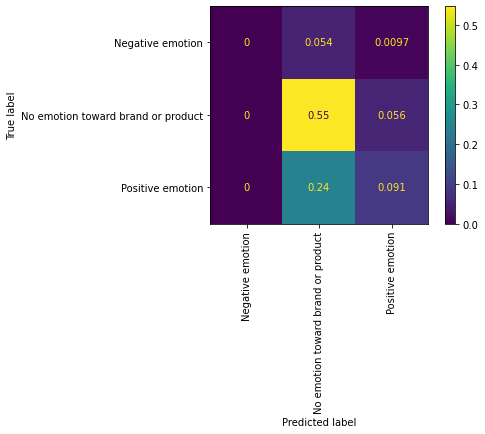

In [334]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(final_model, 
                      X_test_vectorized, 
                      y_test, 
                      xticks_rotation='vertical',
                      normalize='all');

Our model is currently not predicting that any tweets are negative.  This is most likely because there were relatively so few negative tweets in our training and test sets.  With so few tweets, our model could not accurately identify them.

# Text Patterns

Before moving on to my recommendations, I thought it would be interesting to create Word Clouds for positive and negative tweets.

In [335]:
# Create a dataframe with the text and the target
train_set = pd.concat([X_train_preprocessed, y_train], axis=1)

In [336]:
train_set.head()

,product,final_text,sentiment
298,Apple,temporary store open 6th congress tomorrow,No emotion toward brand or product
4176,Apple,delivery pop store quite possible,Positive emotion
882,Apple,think might go weekend without seeing case twice,Positive emotion
776,Google,launch major new social network called circle ...,Positive emotion
622,Google,host developer day,No emotion toward brand or product


In [337]:
# Create a corpus of the positive tweets
positive_text = train_set['final_text'].loc[train_set['sentiment']=='Positive emotion'].tolist()
positive_text = ' '.join(positive_text)

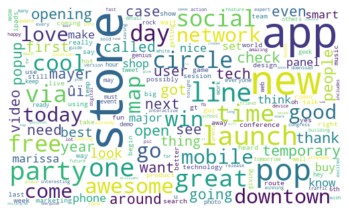

In [338]:
# Generate a word cloud image
wordcloud = WordCloud(width=500, 
                      height=300, 
                      collocations=False,
                      background_color='white',
                      max_font_size=70).generate(positive_text)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

In [339]:
# Create a corpus of the negative tweets
negative_text = train_set['final_text'].loc[train_set['sentiment']=='Negative emotion'].tolist()
negative_text = ' '.join(negative_text)

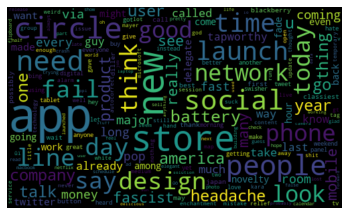

In [340]:
# Generate a word cloud image
wordcloud_2 = WordCloud(width=500,
                      height=300,
                      collocations=False,
                      max_font_size=70).generate(negative_text)

import matplotlib.pyplot as plt
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off");

Many of the highest recurring words in both the positive and negative categories are the same: 'app', 'store', 'new', 'launch', 'line'.  This could be why our model is not performing at a level that we would prefer.

Looking closely, there are some words that I would expect to see in each word cloud.  For example, 'great', 'awesome', and 'cool' in the positive word cloud and 'fail', 'headache', and 'fascist' in the negative word cloud.

# Conclusion and Recommendations

## Conclusion

After our natural language processing, our model is only performing at 64% on our testing set.  This is only slightly higher (4%) than if we were to assign all the tweets as 'No Emotion'.  

Although we would prefer a model that performs at a higher level, we were constricted by the dataset.  The dataset our model trained on included a much higher level of 'No Emotion' (60.2%) tweets than 'Positive' or 'Negative' tweets combined (39.8%).

## Recommendations

My main recommendation to South by Southwest would be to collect more tweets that are identified as positive or negative.  By increasing the number of tweets our model trains on, it would have the information it needs to become more accurate.

Additionally, identifying and removing more SXSW specific stopwords could distill our tokens to words that have a semantic value.

Finally, after completing these steps, I would recommend continuing to use the Multinomial Naive Bayes model with lemmatization to make predictions on future tweets.

# Next Steps

**Exploring sentiments for specific products**

Diving into which products are tweeted about favorably vs which ones are getting negative attention.  This could help SXSW know which vendors are worth inviting/promoting.

**Part of speech tagging for accurate lemmatization.**

Currently, our lemmatization is only functioning for nouns, not for verbs (ex: 'calling' is not lemmatized to 'call').  By instituting part of speech tagging to identify verbs and then lemmatize them could help our model's performance.